### **PyTorch NN Module**

In [88]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt  
import seaborn as sns

# Data Preprocessing Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [89]:
# Using Breast Cancer Detection Dataset

df = pd.read_csv('https://raw.githubusercontent.com/gscdit/Breast-Cancer-Detection/refs/heads/master/data.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [90]:
df.shape

(569, 33)

In [91]:
df.drop(['id', 'Unnamed: 32'], axis=1, inplace=True)

/tmp/ipython-input-4081543843.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='diagnosis', data=df, palette='viridis')


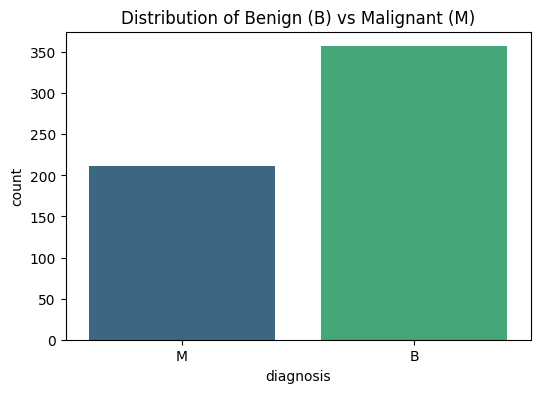

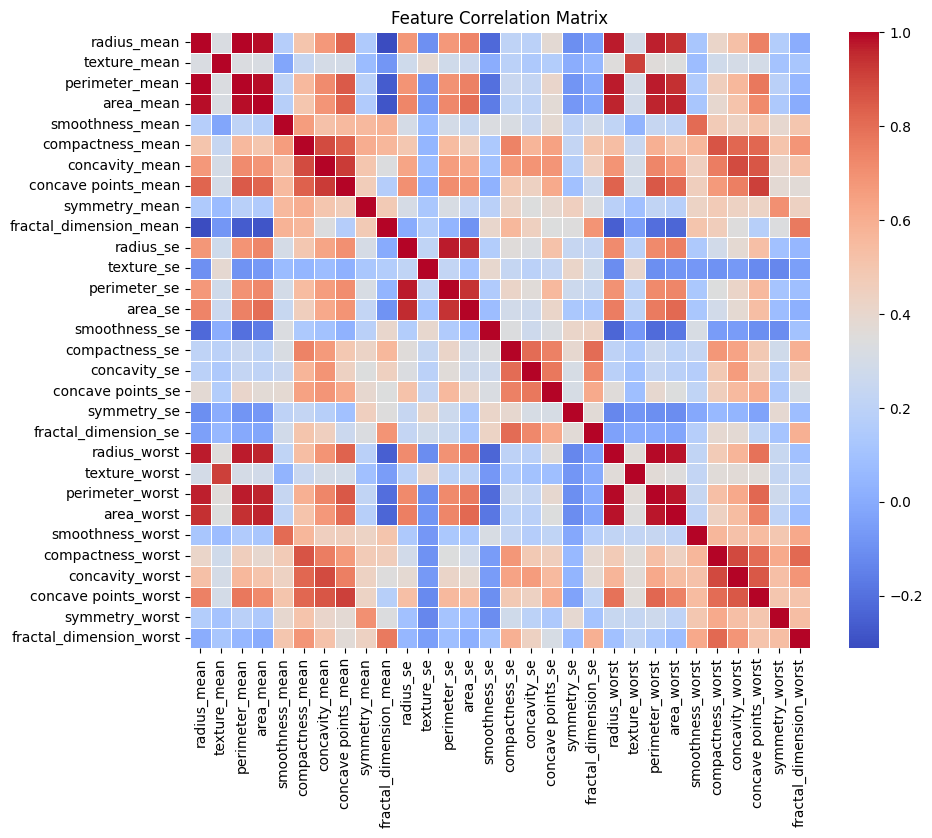

In [92]:
# %% [markdown]
# ### Visualizing Data Distribution
# %%
# 1. Target Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='diagnosis', data=df, palette='viridis')
plt.title('Distribution of Benign (B) vs Malignant (M)')
plt.show()

# 2. Correlation Matrix
plt.figure(figsize=(10, 8))
# We only use numeric columns for correlation
numeric_df = df.iloc[:, 1:] 
sns.heatmap(numeric_df.corr(), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

In [93]:
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [94]:
# Splitting the dataset into features and target variable
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 1:], df.iloc[:, 0], test_size=0.2)

In [95]:
# scalar object
scaler = StandardScaler()

# 
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [96]:
X_train

array([[ 0.61634383,  0.44207617,  0.6243953 , ...,  0.254665  ,
         0.88311075, -0.44789916],
       [-1.23359807, -1.74584438, -1.25481585, ..., -1.74088826,
         0.28932766, -0.14814973],
       [-1.25405056, -0.25522348, -1.2443665 , ..., -0.74311163,
         0.39858375,  0.06201294],
       ...,
       [-0.45237066, -0.8930812 , -0.36327729, ...,  0.90717442,
         1.68273865,  2.26843923],
       [-0.46965445, -0.48613255, -0.44394627, ..., -0.24969892,
        -0.16353091,  1.55850636],
       [-0.42068371, -0.12262224, -0.3904456 , ..., -0.33168087,
        -1.26875917, -0.69074128]])

In [97]:
y_train

,diagnosis
132,M
140,B
470,B
243,B
432,M
...,...
3,M
328,M
5,M
383,B


In [98]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)


In [99]:
y_train

array([1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,

In [100]:
# Converting numpy arrays to torch tensors

X_train_tensor = torch.from_numpy(X_train).float()
X_test_tensor = torch.from_numpy(X_test).float()

y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1)

In [101]:
X_train_tensor.shape
print(X_train_tensor)

tensor([[ 0.6163,  0.4421,  0.6244,  ...,  0.2547,  0.8831, -0.4479],
        [-1.2336, -1.7458, -1.2548,  ..., -1.7409,  0.2893, -0.1481],
        [-1.2541, -0.2552, -1.2444,  ..., -0.7431,  0.3986,  0.0620],
        ...,
        [-0.4524, -0.8931, -0.3633,  ...,  0.9072,  1.6827,  2.2684],
        [-0.4697, -0.4861, -0.4439,  ..., -0.2497, -0.1635,  1.5585],
        [-0.4207, -0.1226, -0.3904,  ..., -0.3317, -1.2688, -0.6907]])


In [102]:
y_train_tensor.shape
print(f"Shapes verified: X={X_train_tensor.shape}, y={y_train_tensor.shape}")

Shapes verified: X=torch.Size([455, 30]), y=torch.Size([455, 1])


In [103]:
# Create Model Class
import torch.nn as nn

# nn.Module as a blueprint provided by PyTorch. 
# By saying class NeuralNet(nn.Module), we are telling python to use all the super powers of PyTorch's nn.Module class.
class NeuralNet(nn.Module):
    
    def __init__(self, num_features):
        super().__init__() # <--- The "Boilerpalte" line.

        # This is the "Stack of Layers" that we will use in our Neural Network.
        # (Pipe)Sequential is a container that allows us to stack layers together.
        self.network = nn.Sequential(

            # Layer 1 : The input layer -> hidden layer
            nn.Linear(num_features, 16),

            # Layer 1 : The "Spark" : The activation function introduces non-linearity to the model.
            nn.ReLU(),

            # Layer 2 : The hidden layer -> output layer
            nn.Linear(16, 8),
            nn.ReLU(),

            # Layer 3 : The output layer
            nn.Linear(8, 1),
            # The "Squish" : The activation function for output layer to convert it to probability.
            nn.Sigmoid()
        )

    # 
    def forward(self, features):
        out = self.network(features) # <--- Pass data through the pipe we made above
        return out

In [104]:
# create dataset
features = X_train_tensor

# Create model
model = NeuralNet(features.shape[1])

## call the model for forward pass
# model.forward(features)
prediction = model(features)

In [105]:
# show model weights
model.network[0].weight

Parameter containing:
tensor([[-8.2853e-02, -8.5334e-02, -1.5903e-01, -6.3339e-02, -1.3223e-02,
          7.0233e-02,  1.1955e-01, -1.4090e-01, -1.6162e-01,  1.3098e-03,
          1.3332e-01,  1.7138e-01, -2.4250e-02,  1.4198e-01,  7.7505e-02,
         -6.4521e-02,  1.4834e-01, -1.7342e-01,  4.2849e-02,  1.7451e-01,
         -1.2297e-01, -1.5428e-01,  4.1080e-02,  1.5450e-01, -1.7764e-01,
          1.4241e-01, -5.5717e-02,  1.2237e-01, -1.6020e-01,  1.5171e-01],
        [ 5.8064e-02, -1.7915e-01, -9.2693e-02,  3.3326e-02,  1.1093e-01,
         -9.1314e-02, -1.6192e-01,  1.9541e-02, -1.6363e-01,  1.0071e-01,
         -8.7496e-02, -3.4078e-03,  1.5994e-01, -1.4402e-01,  1.6679e-01,
         -6.1069e-02, -1.0224e-01, -9.8407e-03,  7.8725e-03, -2.4229e-02,
         -9.5575e-02,  3.6864e-02, -5.1851e-02, -5.3807e-02,  7.8993e-02,
         -5.0134e-02,  1.3849e-02,  1.8159e-01, -2.9219e-02, -1.8182e-01],
        [-8.6526e-02,  1.6170e-01,  5.8176e-02,  2.3071e-02, -1.2543e-01,
         -9.47

In [106]:
# Calculating loss (The scoreboard) 
# "BCELoss" stands for Binary Cross Entropy !
criterion = nn.BCELoss()

# this will update the weights of the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# calcualte loss using the criterion
loss = criterion(prediction,  y_train_tensor)

# backpropagation
loss.backward()
optimizer.step()

The Trainigng Loop (The learning Phase)

In [107]:
loss_values = []

num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(features)

    # Calculate Loss
    loss = criterion(y_pred, y_train_tensor)

    # --- NEW: Save the loss for the graph ---
    loss_values.append(loss.item())
    
    # Back propagation
    optimizer.zero_grad() # clear previous gradients (Crucial step)
    loss.backward()
    optimizer.step()    # update weights

    # Print loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.3909
Epoch [20/100], Loss: 0.1364
Epoch [30/100], Loss: 0.0753
Epoch [40/100], Loss: 0.0578
Epoch [50/100], Loss: 0.0462
Epoch [60/100], Loss: 0.0372
Epoch [70/100], Loss: 0.0292
Epoch [80/100], Loss: 0.0223
Epoch [90/100], Loss: 0.0166
Epoch [100/100], Loss: 0.0120


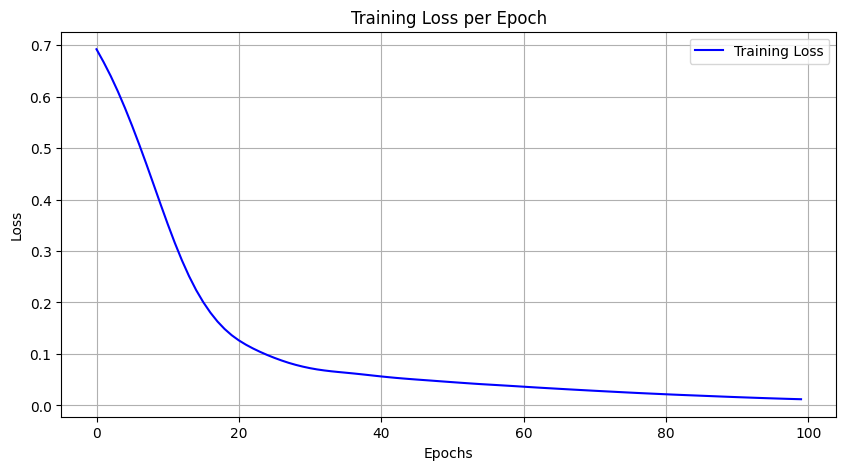

In [108]:
plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Training Loss', color='blue')
plt.title('Training Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [109]:
model.eval()  # set the model to evaluation mode

with torch.no_grad():
    y_test_pred = model(X_test_tensor)
    y_test_pred_cls = y_test_pred.round()  # Convert probabilities to 0 or 1
    accuracy = (y_test_pred_cls.eq(y_test_tensor).sum().item()) / y_test_tensor.shape[0]
    print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 96.49%


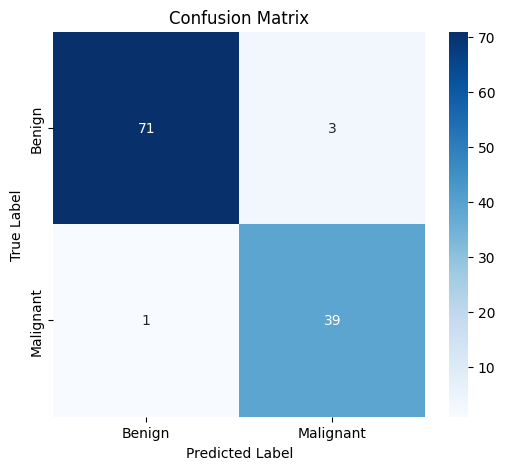

In [110]:
# %%
from sklearn.metrics import confusion_matrix

# Ensure we are in eval mode
model.eval()

# Generate predictions again for the confusion matrix
with torch.no_grad():
    y_test_pred = model(X_test_tensor)
    y_test_pred_cls = y_test_pred.round() 

# Convert tensors to numpy arrays
y_true = y_test_tensor.numpy()
y_pred = y_test_pred_cls.numpy()

# Calculate Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Malignant'], 
            yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [111]:
%pip install torchinfo

In [112]:
from torchinfo import summary

# input_size format: (batch_size, num_features)
# Your dataset has 30 features, so use (1, 30) for a single sample
summary(model, input_size=(1, 30))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNet                                [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 16]                   496
│    └─ReLU: 2-2                         [1, 16]                   --
│    └─Linear: 2-3                       [1, 8]                    136
│    └─ReLU: 2-4                         [1, 8]                    --
│    └─Linear: 2-5                       [1, 1]                    9
│    └─Sigmoid: 2-6                      [1, 1]                    --
Total params: 641
Trainable params: 641
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00